# Clustering

### Due to the fact that we decided to use a subset of the data for this preliminary analysis, we will use the original dataframe without the rows that are not correct and we will correct them for the future analysis.


In [1]:
#import final_clean.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Read in the data
final_clean = pd.read_csv('../dataset/data/final_clean.csv')
#show the number of rows and columns
final_clean.shape


(51267, 31)

### We are left with a fraction of the original data, but it is still enough to work with, at least for this first part. 


# -----------------------------------------------------------------------------------------------------------------------------

# K-MEANS CLUSTERING

### But to be used with Clustering algorithm like K-means, we need to have numerical values, so we will drop the categorical columns and we will use the numerical ones.
### Then we will also remove the outliers, by simply removing the rows that have a value that is below the 25th percentile or above the 75th percentile.

In [2]:
no_outliers = final_clean.copy()
numeric_cols = no_outliers.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    q1 = no_outliers[col].quantile(0.25)
    q3 = no_outliers[col].quantile(0.75)
    iqr = q3 - q1
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    no_outliers = no_outliers[(no_outliers[col] >= fence_low) * (no_outliers[col] <= fence_high)]

### We can now use the K-means algorithm to cluster the data. We will use the elbow method to find the optimal number of clusters.

100%|██████████| 8/8 [02:59<00:00, 22.44s/it]


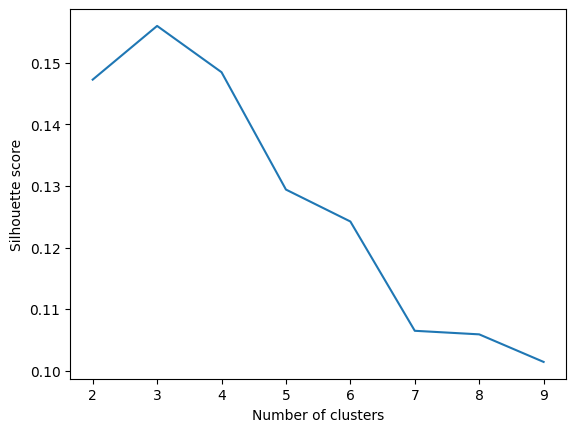

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
sample = final_clean.sample(frac=0.5).copy()
numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants', 'max_age_participants',  'n_participants', 'timestamp', 'povertyPercentage', 'p_males', 'p_females', 'p_participants_child', 'p_participants_teen', 'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested', 'p_unharmed', 'month_cd_change_min_age_participants', 'month_cd_change_avg_age_participants', 'month_cd_change_max_age_participants', 'month_cd_ratio_males', 'month_cd_ratio_females', 'month_cd_ratio_participants_child', 'month_cd_ratio_participants_teen', 'month_cd_ratio_participants_adult', 'month_cd_ratio_killed', 'month_cd_ratio_injured', 'month_cd_ratio_arrested', 'month_cd_ratio_unharmed', 'month_cd_incidents', 'month_cd_votes_incidents', 'cd_population', 'percentage_republican', 'percentage_democrat', 'cd_month_SHOT_INJURED', 'cd_month_SHOT_DEAD', 'cd_month_NON_SHOOTING', 'cd_month_SHOTS_FIRED_UNHARMED', 'cd_month_OTHER']

# to_drop = ['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1', 'date_day', 'city_or_county', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'party', 'candidatevotes', 'totalvotes', 'state_population']
numeric = sample[numeric_cols]
k_min = 2
k_max = 10
# Sample
# Standardize
# scaler = MinMaxScaler()
# numeric_scaled = scaler.fit_transform(numeric)
# numeric_scaled = np.log(numeric_scaled + 1)
numeric_scaled = numeric
# PCA
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_scaled)
# KMeans
scores = []
for k in tqdm(range(k_min, k_max)):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(numeric_scaled)
    score = silhouette_score(numeric_scaled, kmeans.labels_)
    scores.append(score)
plt.plot(range(k_min, k_max), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

### As we can see from the graph, the optimal number of clusters is 3, because it's the highest point of the curve.
### We will use 3 as the number of clusters for the K-means algorithm, and we will use PCA to reduce the dimensionality of the data to 2, so we can plot the clusters.


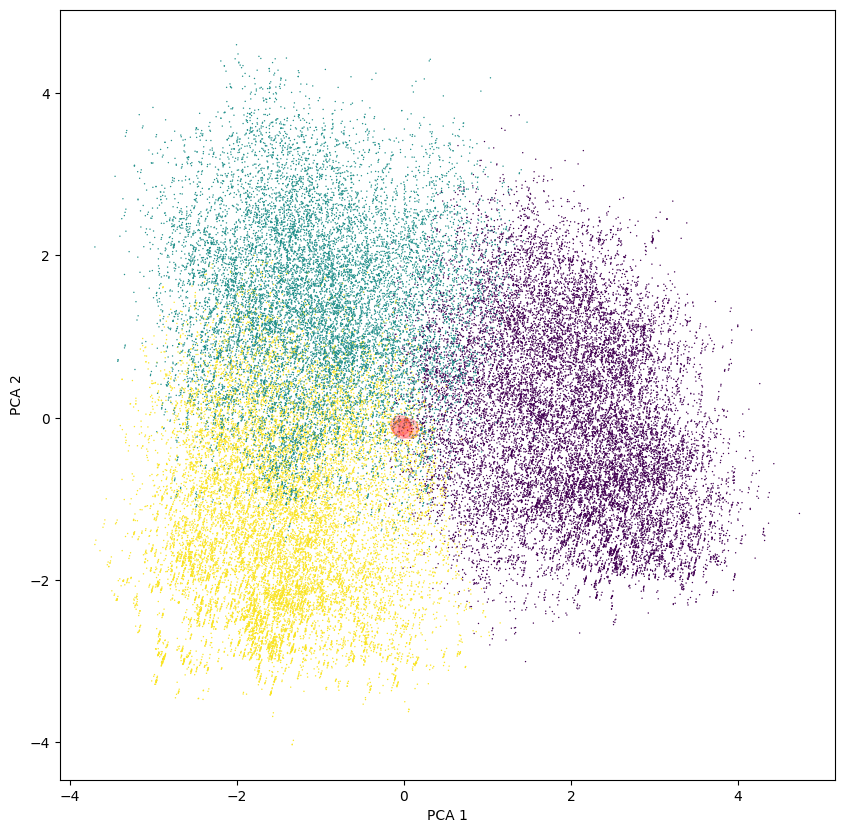

In [4]:
for i in [0]:
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans

    numeric_cols = final_clean.select_dtypes(include=['float64', 'int64']).columns
    numeric_scaled = final_clean[numeric_cols]

    # PCA
    pca = PCA(n_components=2)
    numeric_pca = pca.fit_transform(numeric_scaled)

    # KMeans
    scores = []
    k = 3
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=42).fit(numeric_scaled)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], c=kmeans.labels_, s=1, edgecolors='black', linewidths=0.001)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=200, alpha=0.2)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.show()



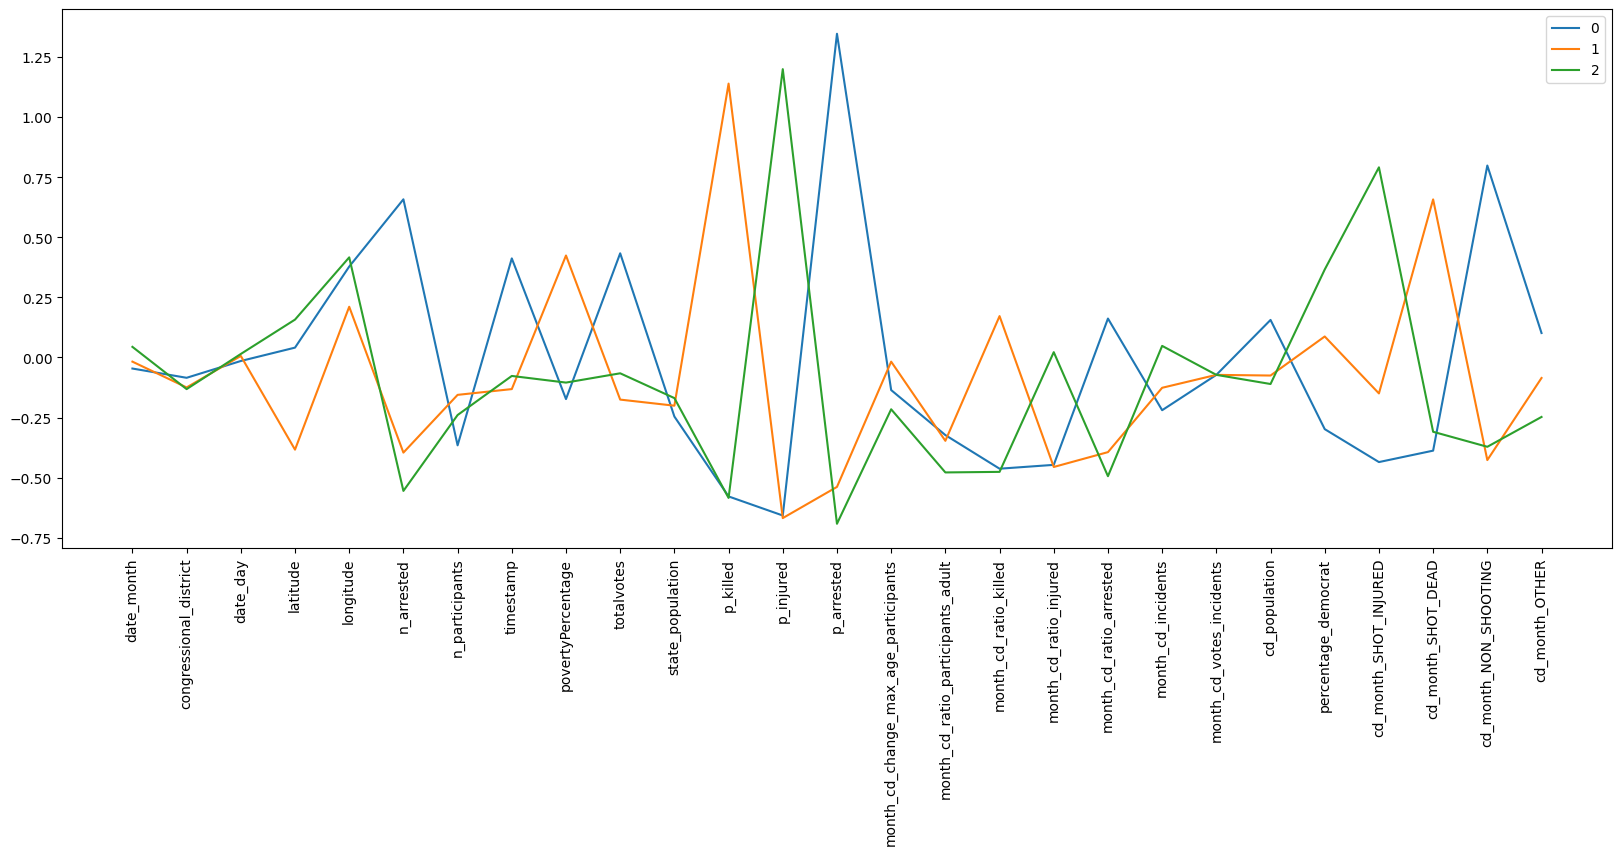

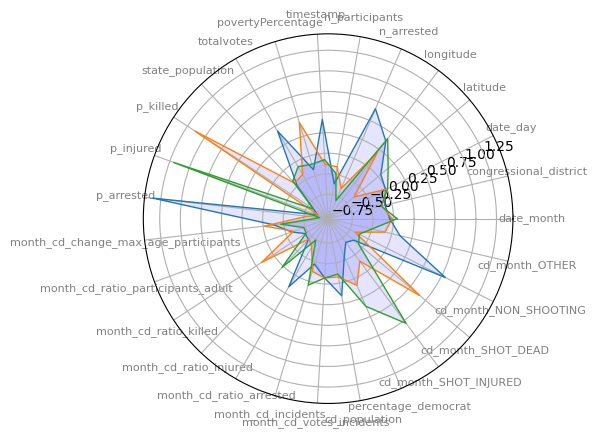

In [5]:
#Let's visualize the centroids of each cluster in the original feature space with two plots: a line plot and a radar plot.
plt.figure(figsize=(20, 7))
tran = kmeans.cluster_centers_
plt.plot(tran.T)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation='vertical')
plt.legend(range(k))
plt.show()

from math import pi
 
# number of variable
N = len(numeric_scaled.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(kmeans.cluster_centers_)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = kmeans.cluster_centers_[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the radar plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_scaled.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

### The following graphs will show the values of each attribute for each cluster

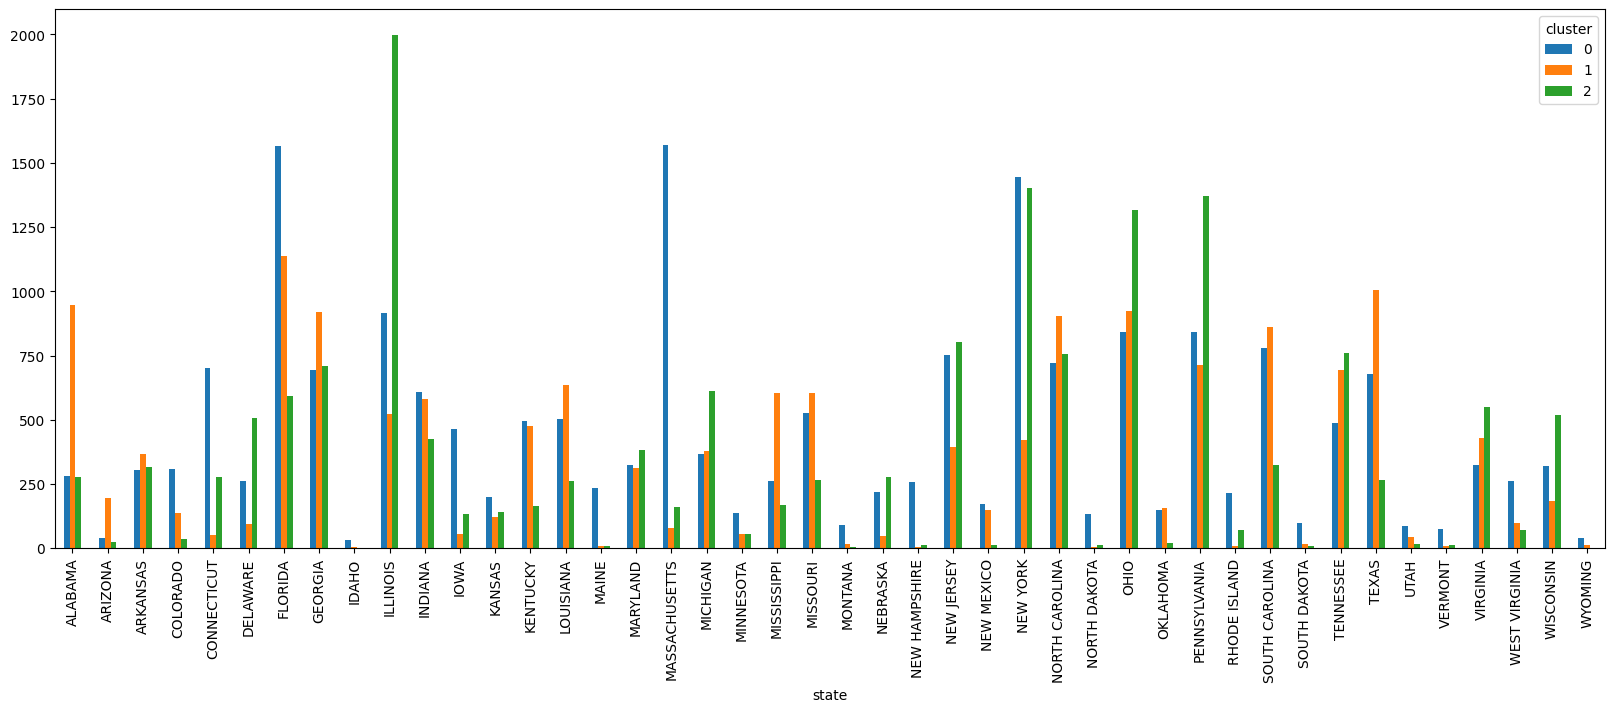

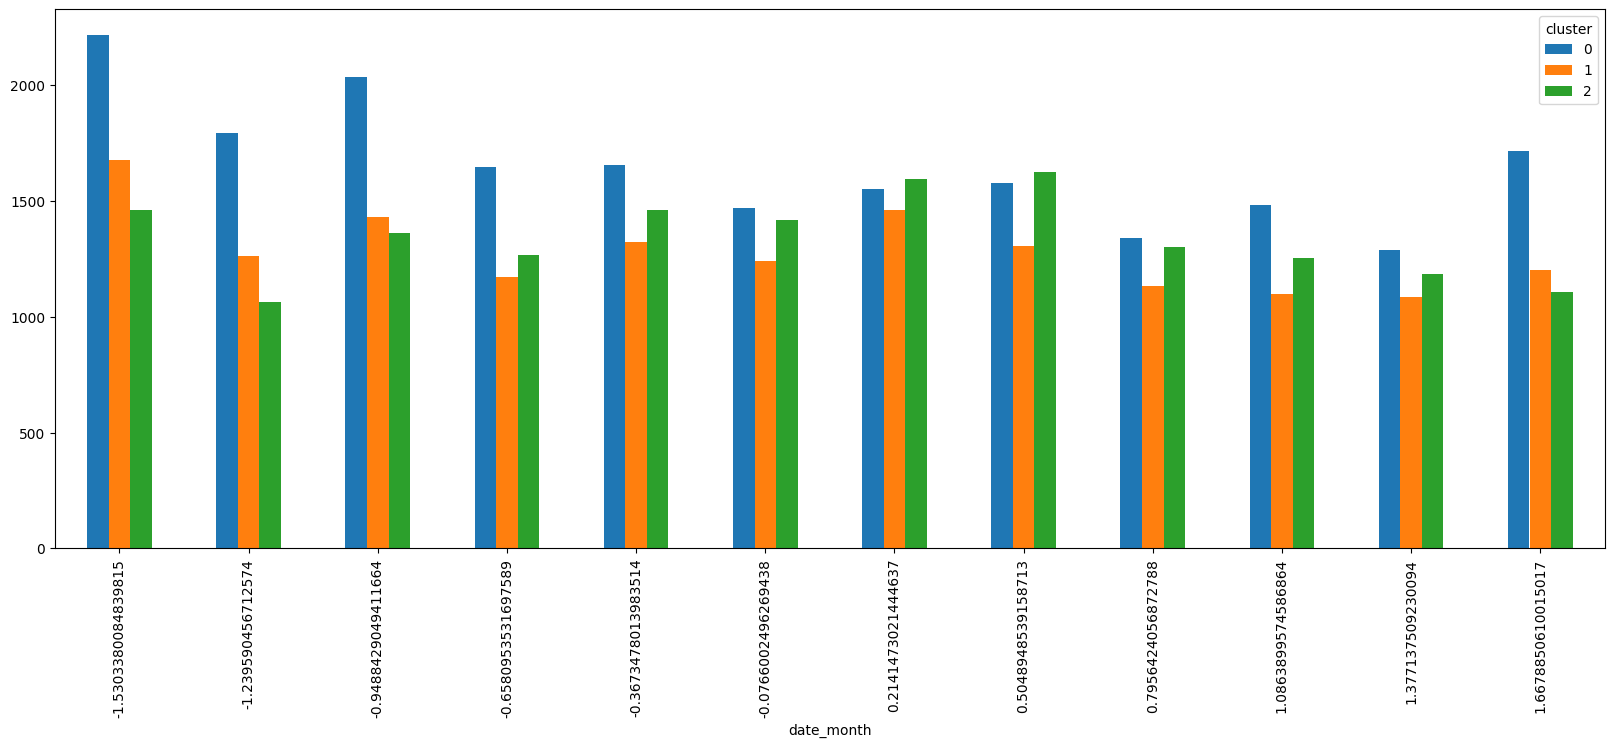

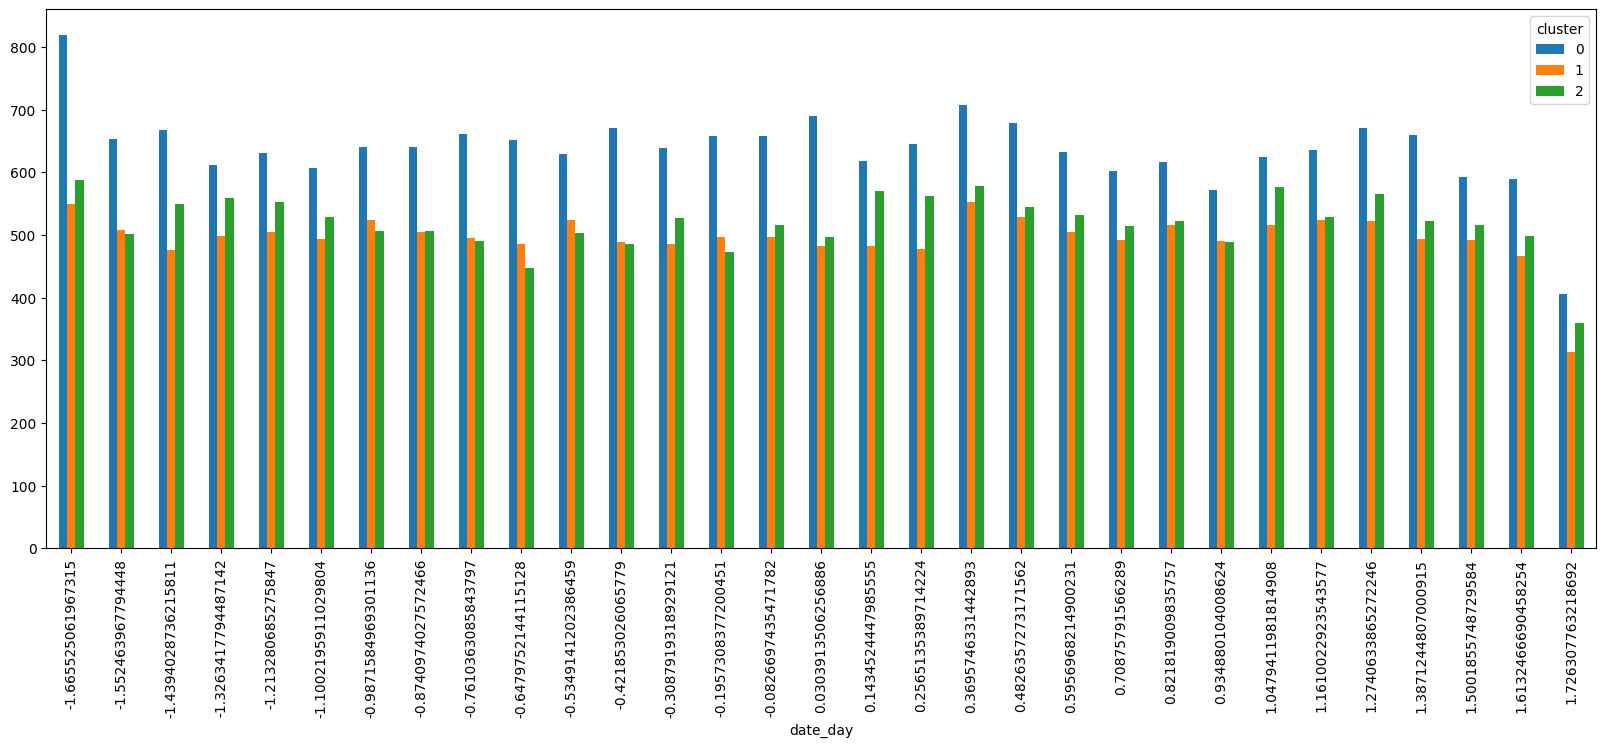

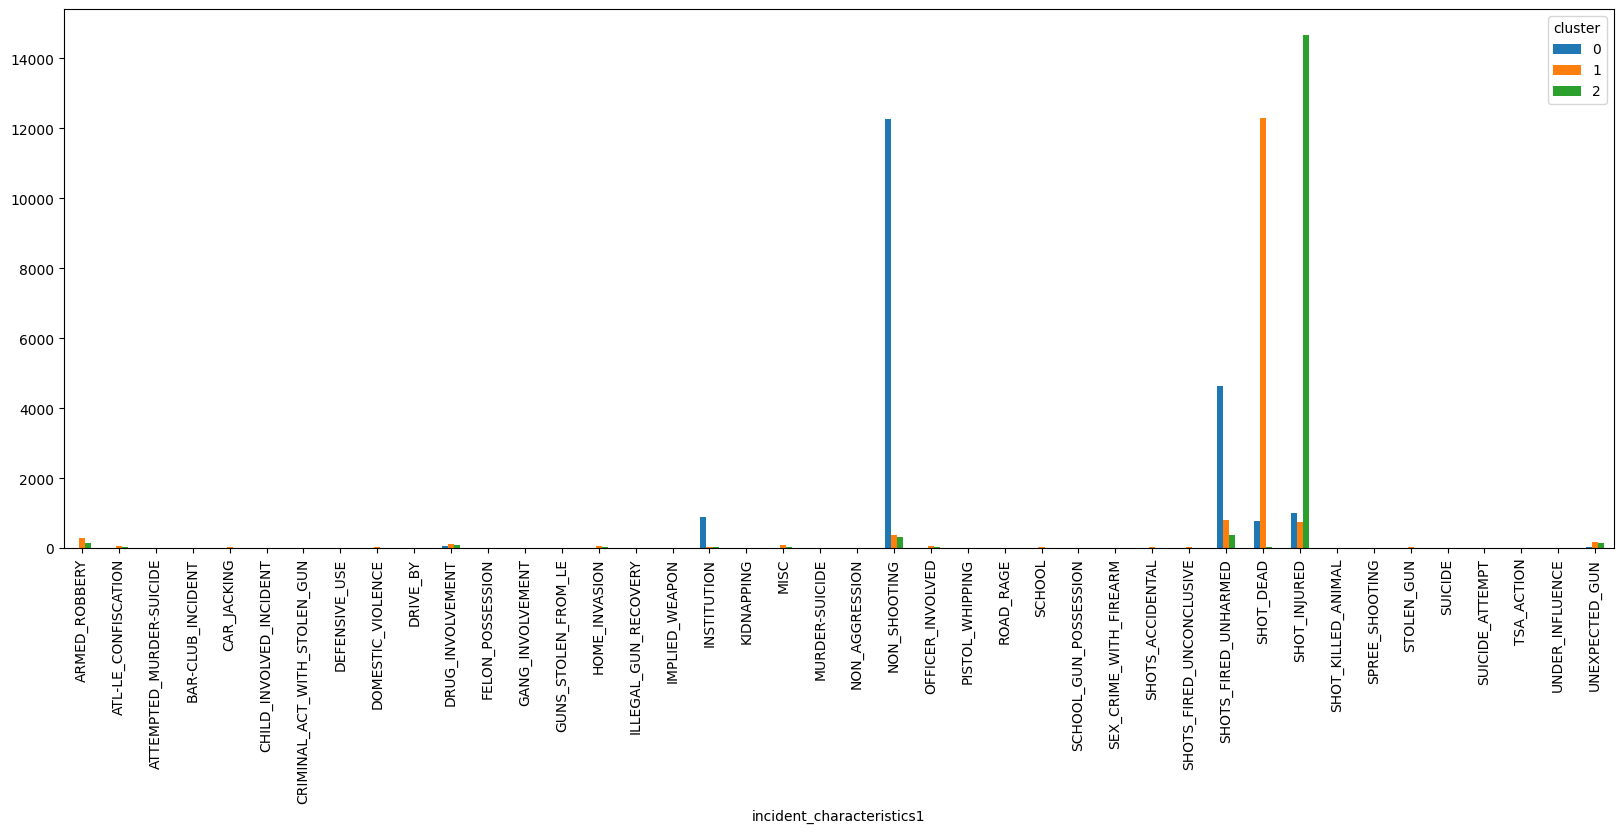

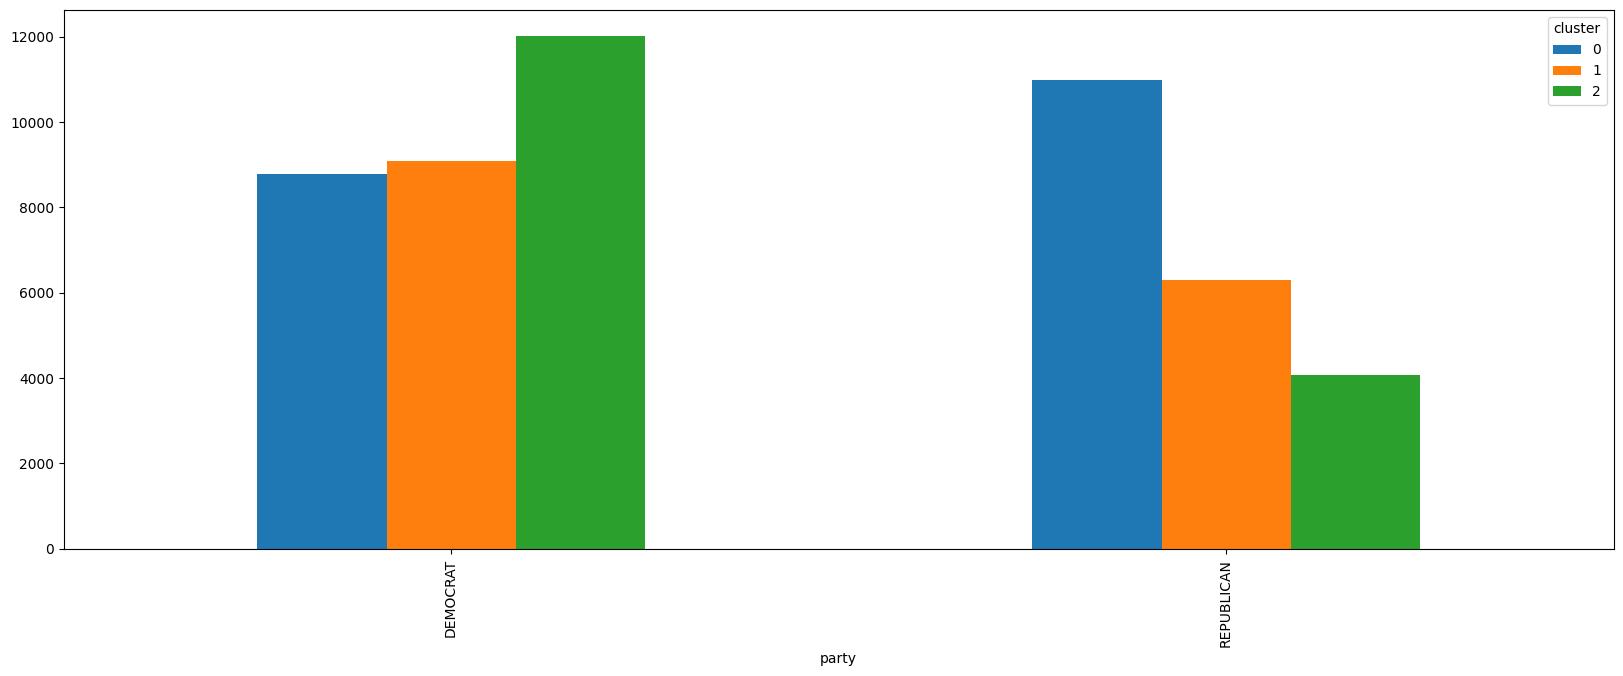

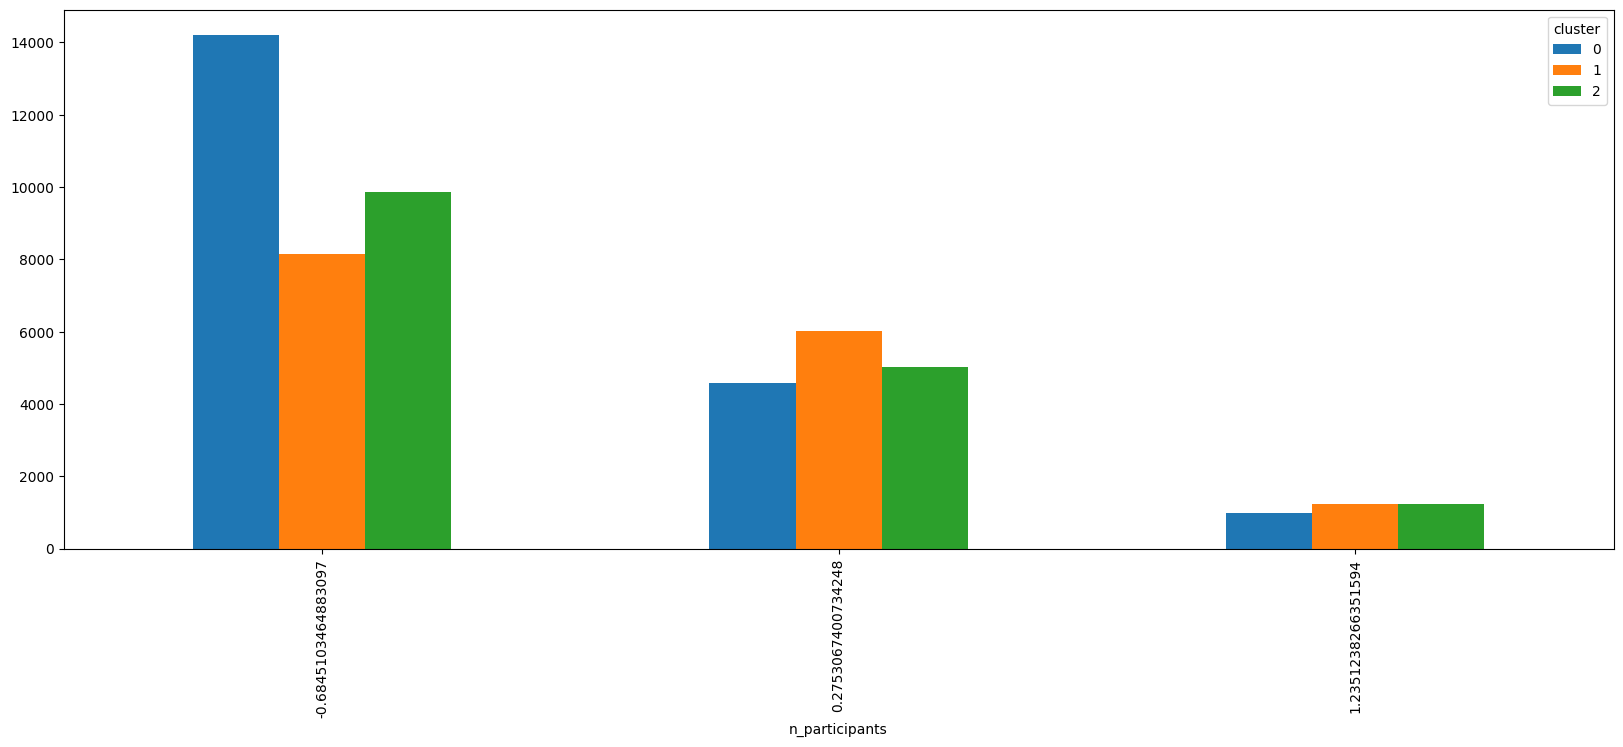

In [6]:


w_clusters = final_clean.copy()
w_clusters['cluster'] = kmeans.labels_
w_clusters = w_clusters.sort_values(by=['cluster'])

o = w_clusters.select_dtypes(include=['float64', 'int64']).columns

cats = ['state', 'date_month', 'date_day', 'incident_characteristics1', 'party', 'n_participants']
for cat in cats:
    xt = pd.crosstab(w_clusters[cat], w_clusters['cluster'])
    xt['total'] = xt.sum(axis=1)
    del xt['total']
    xt = xt.sort_index()
    xt.plot.bar(stacked=False, figsize=(20, 7))
    plt.show();

# -----------------------------------------------------------------------------------------------------------------------------

# D-BSCAN CLUSTERING

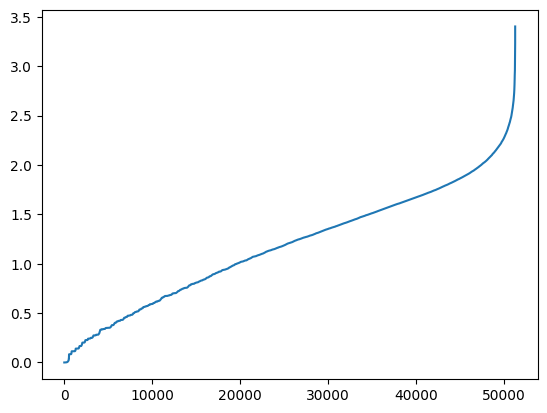

In [7]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# NN
nn = NearestNeighbors(n_neighbors=2*numeric_scaled.shape[1])
nn.fit(numeric_scaled)
distances, indices = nn.kneighbors(numeric_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()


[-1  0  1  2  3]
(51267,)
(51267, 27)


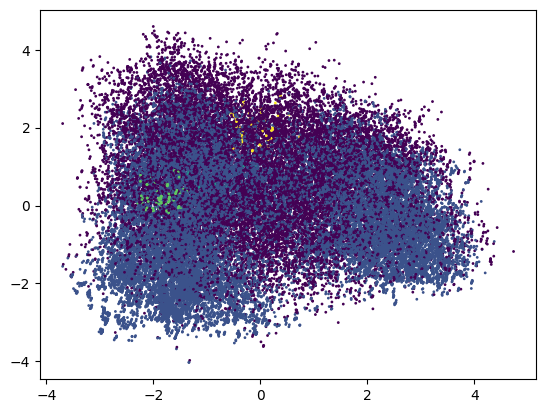

In [8]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#we use the epsilon value of 2.2 and the minimum number of samples of 2 times the number of dimensions
dbs = DBSCAN(eps=2.2, min_samples=2*numeric_scaled.shape[1])
dbs.fit(numeric_scaled)
labels = dbs.labels_
print(np.unique(labels))
print(labels.shape)
print(numeric_scaled.shape)

# UMAP
pca = PCA(n_components=2)
numeric_pca = pca.fit_transform(numeric_scaled)

plt.scatter(numeric_pca[:, 0], numeric_pca[:, 1], s=1, c=labels)
plt.show()